## PyTorch Tutorial!!!
In this assignment, you will be familiarized with the usage of the PyTorch library and how to build a model in two ways  
It's quite similar to TensorFlow
*   using the inbuilt layers in pytorch
*   using custom layers to replicate the same result

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Loading and preprocessing the Data
We will directly be using the dataset included in literally any library that exists. MNIST really is THAT popular.  
Link: https://docs.pytorch.org/vision/0.9/datasets.html#mnist

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

## Making a simple feedforward network

The following is a simple feedforward model with three layers:
* a flatten layer to convert our 28x28 images into a single array of length 784
* a dense layer of 128 neurons with the relu activation function
* finally a dense layer of 10 neurons with the softmax activation to get a distribution between the digits

In [7]:
# Build the model
SequentialNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)


### Training and Testing loops

In [8]:
# Training loop
def train(model, loader, optimizer, loss_fn, epochs=5):

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()                          #####################
            optimizer.step()                         #####################
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        if epoch%8>=0:
          test(model,train_loader)
          test(model,test_loader)
# Testing loop
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)        ######################
            logits = model(x)
            pred = logits.argmax(dim=1)              ######################
            correct += (pred == y).sum().item()      ######################
            total += y.size(0)


    print(f"Accuracy: {100 * correct / total:.2f}%")


### Training the sequential model

In [9]:
print("\nTraining SequentialNet")
sequential_model = SequentialNet.to(device)
optimizer_seq = optim.Adam(sequential_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train(sequential_model, train_loader, optimizer_seq, loss_fn)
test(sequential_model, test_loader)


Training SequentialNet
Epoch 1, Loss: 346.3065
Accuracy: 93.89%
Accuracy: 93.40%
Epoch 2, Loss: 163.3016
Accuracy: 96.17%
Accuracy: 95.83%
Epoch 3, Loss: 121.9850
Accuracy: 96.46%
Accuracy: 95.59%
Epoch 4, Loss: 97.4806
Accuracy: 97.39%
Accuracy: 96.78%
Epoch 5, Loss: 84.3127
Accuracy: 97.07%
Accuracy: 96.46%
Accuracy: 96.46%


### Manually building the same network from scratch
You can use the simple sequential model we described above as a reference.

In [11]:
# Custom model
class ManualNet(nn.Module):
    
    def __init__(self):
        super(ManualNet, self).__init__()
        # TODO: Define your paramters using nn.Parameters (the layers)
        self.layer_1_weights=nn.Parameter(torch.randn(784,128)*0.01)
        self.layer_1_bias=nn.Parameter(torch.randn(1,128))
        self.layer_2_weights=nn.Parameter(torch.randn(128,64)*0.01)
        self.layer_2_bias=nn.Parameter(torch.randn(1,64))
        self.output_weights=nn.Parameter(torch.randn(64,10)*0.01)
        self.output_bias=nn.Parameter(torch.randn(1,10))
        self.activation_function=nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 784)
        # TODO: Do the forward pass using matrix multiplications and applying activation functions
        x=torch.matmul(x,self.layer_1_weights)
        x+=self.layer_1_bias
        x=self.activation_function(x)
        self.layer_1=x
        x=torch.matmul(x,self.layer_2_weights)
        x+=self.layer_2_bias
        x=self.activation_function(x)
        self.layer_2=x
        x=torch.matmul(x,self.output_weights)
        x+=self.output_bias
        return x

### Training the manual model

In [13]:
manual_model=ManualNet()
manual_model=manual_model.to(device)
def back_propagation(model,x,y,logits,lr):
  ref=torch.zeros((y.shape[0],10)).to(device)
  ref[torch.arange(y.shape[0]), y] = 1
  softmax_logits=torch.exp(logits)/(torch.exp(logits).sum(dim=1,keepdim=True))
  pd_logits=(softmax_logits-ref)
  pd_output_layer_weights=torch.matmul(model.layer_2.T,pd_logits)
  pd_output_layer_bias=pd_logits.sum(dim=0,keepdim=True)
  pd_layer_2=torch.matmul(pd_logits,model.output_weights.T)*((model.layer_2>0).float())
  pd_layer_2_weights=torch.matmul(model.layer_1.T,pd_layer_2)
  pd_layer_2_bias=pd_layer_2.sum(dim=0,keepdim=True)
  pd_layer_1=torch.matmul(pd_layer_2,model.layer_2_weights.T)*((model.layer_1>0).float())
  pd_layer_1_weights=torch.matmul(x.view(-1, 784).T,pd_layer_1)
  pd_layer_1_bias=pd_layer_1.sum(dim=0,keepdim=True)
  with torch.no_grad():
    model.layer_1_weights-=lr*pd_layer_1_weights
    model.layer_1_bias-=lr*pd_layer_1_bias
    model.layer_2_weights-=lr*pd_layer_2_weights
    model.layer_2_bias-=lr*pd_layer_2_bias
    model.output_weights-=lr*pd_output_layer_weights
    model.output_bias-=lr*pd_output_layer_bias
def cross_entropy_loss(logits,result):
  softmax_logits=torch.exp(logits)/(torch.exp(logits).sum(dim=1,keepdim=True))
  loss=(-((torch.log(softmax_logits[torch.arange(result.shape[0]),result]))).sum()).item()
  return loss
def train_manual_model(model,loader,epoch,learning_rate):
  for i in range(epoch):
    total_loss=0
    for x,y in loader:
      x,y=x.to(device),y.to(device)
      logits=model(x)
      softmax_loss=cross_entropy_loss(logits,y)
      total_loss+=softmax_loss
      back_propagation(model,x,y,logits,learning_rate)
    print(f"epoch {i+1} Loss {total_loss} ")
    print("Training Data ",end="")
    test(manual_model,train_loader)
    print("Testing Data ",end="")
    test(manual_model,test_loader)
    
train_manual_model(manual_model,train_loader,7,0.001)
print("Accuracy Of The Model")
test(manual_model,test_loader)

epoch 1 Loss 63903.11894798279 
Training Data Accuracy: 89.05%
Testing Data Accuracy: 89.41%
epoch 2 Loss 17986.71471786499 
Training Data Accuracy: 93.49%
Testing Data Accuracy: 93.58%
epoch 3 Loss 12166.076884508133 
Training Data Accuracy: 95.20%
Testing Data Accuracy: 95.10%
epoch 4 Loss 9186.226110696793 
Training Data Accuracy: 94.49%
Testing Data Accuracy: 94.21%
epoch 5 Loss 7762.185365021229 
Training Data Accuracy: 96.93%
Testing Data Accuracy: 96.53%
epoch 6 Loss 6714.037276864052 
Training Data Accuracy: 97.33%
Testing Data Accuracy: 96.66%
epoch 7 Loss 5906.447676002979 
Training Data Accuracy: 97.33%
Testing Data Accuracy: 96.72%
Accuracy Of The Model
Accuracy: 96.72%


### Visualize the outputs of the models

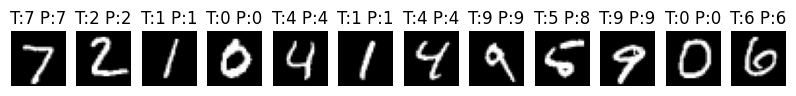

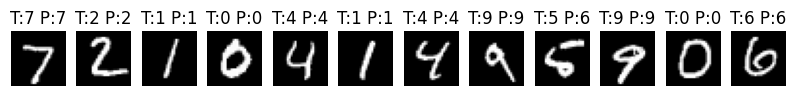

In [14]:
def visualize(model, loader, n=5):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    preds = model(x).argmax(dim=1)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x[i].cpu().squeeze(), cmap='gray')
        plt.title(f"T:{y[i].item()} P:{preds[i].item()}")
        plt.axis('off')
    plt.show()

visualize(manual_model, test_loader,12) # Uncomment this later
visualize(sequential_model, test_loader,12)

## Assignment
* Load and preprocess CIFAR100 dataset (not CIFAR10)
* Build a feedforward network for it. You can experiment around with number of layers and and neurons in each layer and different activation functions
* You are allowed to use nn.functional. (convolutions _might_ make your accuracy better)

In [19]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)


In [33]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        self.conv_layer_1=nn.Conv2d(3,64,3,padding=1)
        self.conv_layer_2=nn.Conv2d(64,64,3,padding=1)
        self.conv_layer_3=nn.Conv2d(64,128,3,padding=1)
        self.conv_layer_4=nn.Conv2d(128,128,3,padding=1)
        self.linear_layer_1=nn.Linear(128*8*8,500)
        self.linear_layer_2=nn.Linear(500,100)

        self.activation_function=nn.ReLU()
        self.pool_layer=nn.MaxPool2d(2,2)

    def forward(self, x):

        x=self.conv_layer_1(x)
        x=self.activation_function(x)
        x=self.conv_layer_2(x)
        x=self.activation_function(x)

        x=self.pool_layer(x)

        x=self.conv_layer_3(x)
        x=self.activation_function(x)
        x=self.conv_layer_4(x)
        x=self.activation_function(x)

        x=self.pool_layer(x)

        x=x.view(-1,128*8*8)
        x=self.linear_layer_1(x)
        x=self.linear_layer_2(x)
        return x


In [36]:
#Training and Testing the Model
model=CNN_Model()
model=model.to(device)
optimizer_seq = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model, train_loader, optimizer_seq, loss_fn,10)
test(model, train_loader)
test(model,test_loader)


Epoch 1, Loss: 2716.6601
Accuracy: 30.65%
Accuracy: 27.88%
Epoch 2, Loss: 2008.8304
Accuracy: 43.91%
Accuracy: 36.59%
Epoch 3, Loss: 1698.0844
Accuracy: 51.86%
Accuracy: 40.64%
Epoch 4, Loss: 1466.1608
Accuracy: 59.61%
Accuracy: 41.28%
Epoch 5, Loss: 1259.6793
Accuracy: 67.00%
Accuracy: 41.84%
Epoch 6, Loss: 1057.5369
Accuracy: 73.01%
Accuracy: 41.12%
Epoch 7, Loss: 862.6424
Accuracy: 78.17%
Accuracy: 39.67%
Epoch 8, Loss: 686.6927
Accuracy: 83.86%
Accuracy: 38.82%
Epoch 9, Loss: 540.7944
Accuracy: 86.89%
Accuracy: 37.79%
Epoch 10, Loss: 436.3257
Accuracy: 88.92%
Accuracy: 37.17%
Accuracy: 88.92%
Accuracy: 37.17%


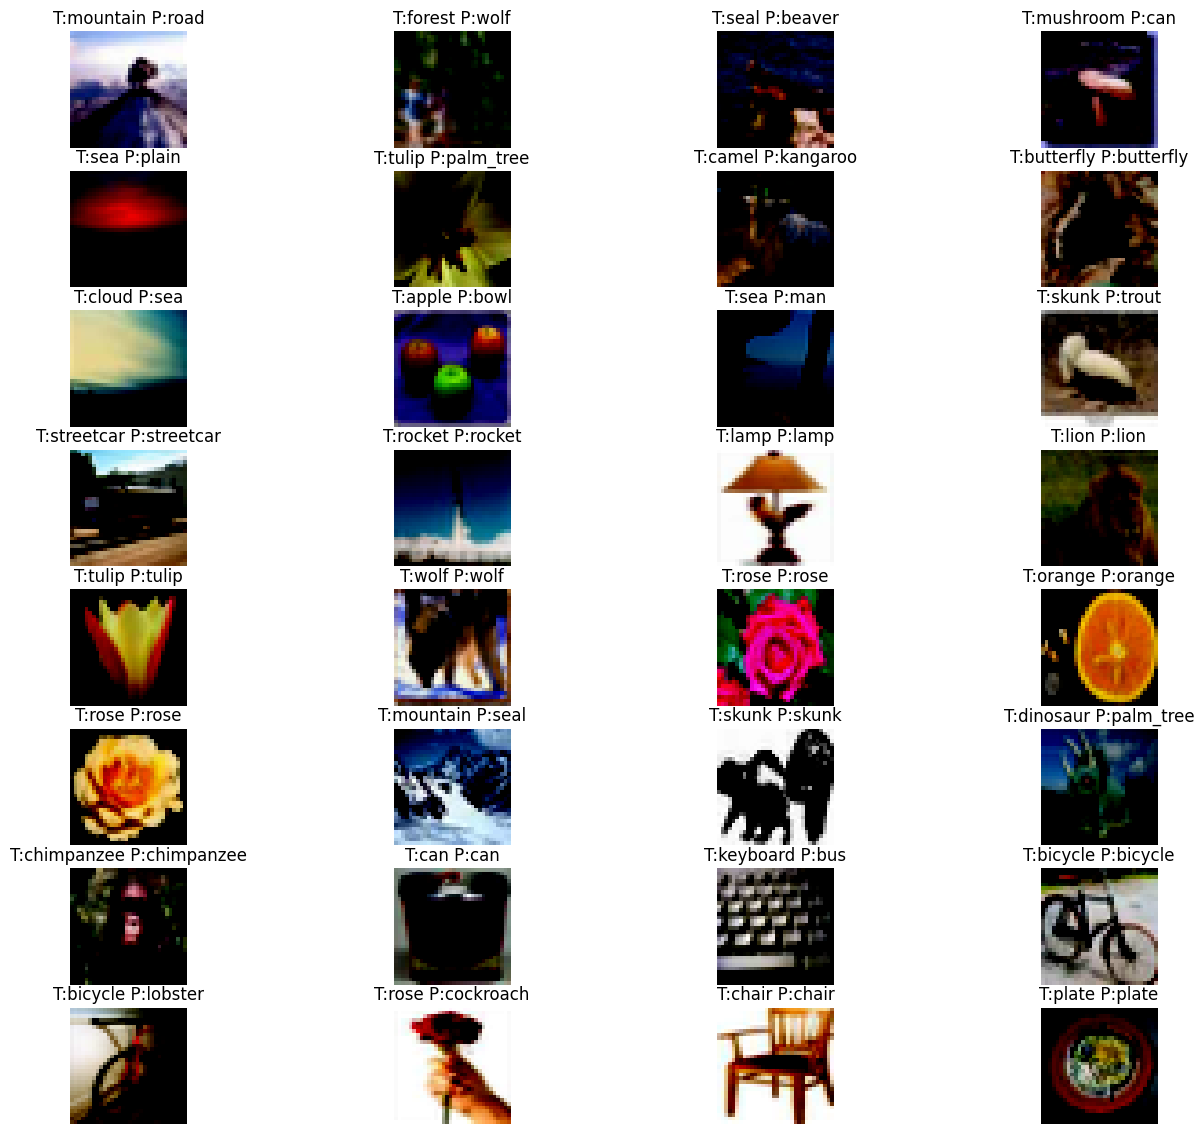

In [37]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
def visualize(model, loader, n=5):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    preds = model(x).argmax(dim=1)

    plt.figure(figsize=(16, 16))
    for i in range(n):
        plt.subplot(n//4+1, 4, i+1)
        plt.imshow(x[i].cpu().squeeze().permute(1,2,0))
        plt.title(f"T:{class_names[y[i]]} P:{class_names[preds[i]]}")
        plt.axis('off')
    plt.show()
visualize(model,test_loader,32)

# Bonus Assignment
* Try the solving the "Titanic Survival Prediction" dataset from kaggle